# Sales Study and Demand Forecasting
The objective of this program is to study the sales' history of a product for a year. Based on that data, we will forecast the sales of the next months.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pylab import rcParams
import statsmodels.api as sm

## Import Sales Data (year)
Import product_sales.csv file and check each column type. One interesting note is that column "Data" is not imported as datetime.

In [2]:
data = pd.read_csv('product_sales.csv', encoding = 'ISO-8859-1', delimiter = ';')

In [3]:
data.dtypes

Pedido         int64
Data          object
Origem         int64
OrigemNome    object
CD            object
CD_Nome       object
Cliente       object
Quantidade     int64
dtype: object

### Edit DataFrame
To be able to use dates properly, we translate the column "Data" to datetime and then we create new columns for day, month, year and day of week.
Also, we add column "qtdPerDay" representing the total sold on the specific day using function groupby.

In [4]:
data['Data'] = pd.to_datetime(data['Data'], format='%d/%m/%Y')
data['day'] = data['Data'].dt.strftime('%d')
data['month'] = data['Data'].dt.strftime('%m')
data['year'] = data['Data'].dt.strftime('%Y')
data['dw'] = data['Data'].dt.dayofweek
data['week'] = data['Data'].dt.week
data['qtdPerDay'] = data.groupby('Data')['Quantidade'].transform('sum')
data.head()

,Pedido,Data,Origem,OrigemNome,CD,CD_Nome,Cliente,Quantidade,day,month,year,dw,week,qtdPerDay
0,5007254627,2019-10-21,2412,CD Salvador,2412,CD Salvador,P_450186682,20,21,10,2019,0,43,8196
1,5007256542,2019-10-21,2412,CD Salvador,2412,CD Salvador,P_450046381,10,21,10,2019,0,43,8196
2,5007257977,2019-10-21,2412,CD Salvador,2412,CD Salvador,P_450044461,10,21,10,2019,0,43,8196
3,5007258496,2019-10-21,2412,CD Salvador,2412,CD Salvador,P_450062547,10,21,10,2019,0,43,8196
4,5007258499,2019-10-21,2412,CD Salvador,2412,CD Salvador,P_450058076,10,21,10,2019,0,43,8196


Now we copy the dataframe and do some changes, droping some columns that are not going to be used.

In [5]:
salesPerDay = data.copy()
salesPerDay.drop(columns=['Pedido', 'Origem', 'OrigemNome', 'CD', 'CD_Nome', 'Cliente', 'Quantidade'], inplace=True)
salesPerDay.drop_duplicates(inplace=True)
salesPerDay.sort_values(by=['Data'], inplace=True)
salesPerDay.reset_index(drop=True, inplace=True)
salesPerDay

,Data,day,month,year,dw,week,qtdPerDay
0,2019-10-21,21,10,2019,0,43,8196
1,2019-10-22,22,10,2019,1,43,11964
2,2019-10-23,23,10,2019,2,43,9399
3,2019-10-24,24,10,2019,3,43,9131
4,2019-10-25,25,10,2019,4,43,7397
...,...,...,...,...,...,...,...
294,2020-10-13,13,10,2020,1,42,21088
295,2020-10-14,14,10,2020,2,42,13879
296,2020-10-15,15,10,2020,3,42,8386
297,2020-10-16,16,10,2020,4,42,15111


### Data Analysis
We are ready for the next step. We'll do some previously analysis on the data we have so we can have some insights before applying forecasting algorithms.

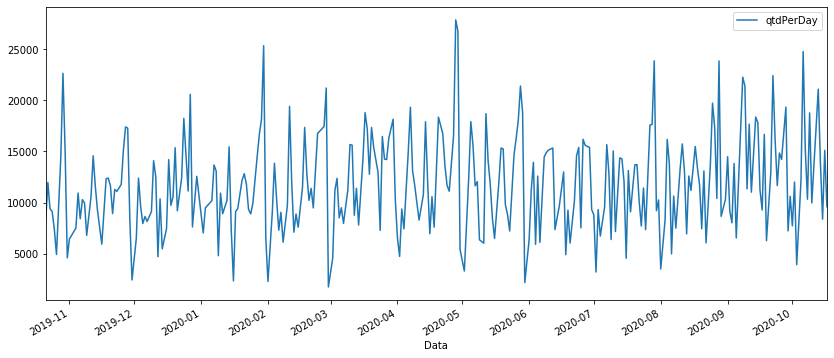

In [10]:
salesPerDay[salesPerDay.Data >= '2019-10-21'].plot(x='Data', y='qtdPerDay', figsize=(14,6))


1) The bigger orders are usually received at the beggining of the week until the midweek. Never in the end and it's very rare to happen on mondays. The day with most orders is Tuesday (dw=1).

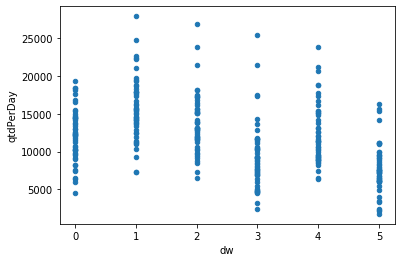

In [11]:
salesPerDay.plot.scatter(x='dw', y='qtdPerDay')

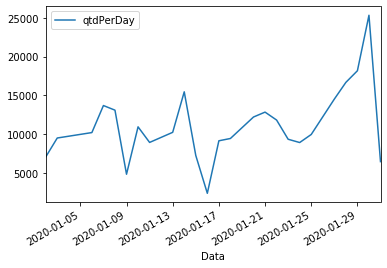

In [12]:
salesPerDay[(salesPerDay.Data >= '2020-01-01') & (salesPerDay.Data < '2020-02-01')].plot(x='Data', y='qtdPerDay')

In [13]:
salesPerDay.sort_values(by='qtdPerDay', ascending=False).head(20)

,Data,day,month,year,dw,week,qtdPerDay
154,2020-04-28,28,04,2020,1,18,27867
155,2020-04-29,29,04,2020,2,18,26784
81,2020-01-30,30,01,2020,3,5,25339
289,2020-10-06,06,10,2020,1,41,24769
231,2020-07-29,29,07,2020,2,31,23861
257,2020-08-28,28,08,2020,4,35,23849
7,2019-10-29,29,10,2019,1,44,22642
277,2020-09-22,22,09,2020,1,39,22412
265,2020-09-08,08,09,2020,1,37,22264
266,2020-09-09,09,09,2020,2,37,21411


2) Plots of each week together:
The conclusion is that we can't just analyze each week separately. The variance is big between each week. Next idea is to take a look considering which part of the month we are analyzing. Probably the end of the month can be more busy than usual.

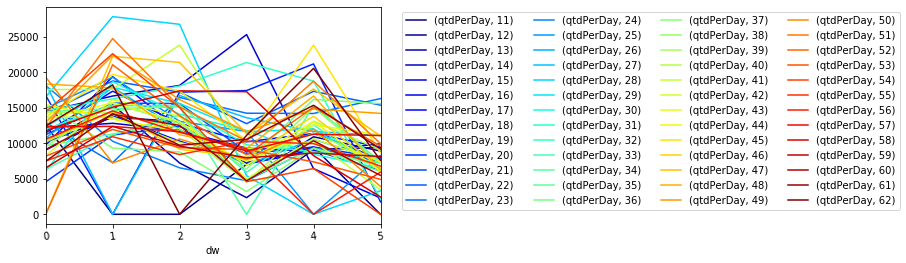

In [14]:
def normweek(year, week, week_ref):
    if year == 2019:
        return (week - week_ref + 1)
    else:
        return (week - week_ref + 52 + 1)
    
dfweek = salesPerDay.copy()
dfweek['week'] = np.vectorize(normweek)(dfweek['year'], dfweek['week'], dfweek['week'].iloc[0])
dfweek.drop(columns=['Data', 'day', 'month', 'year'], inplace=True)
dfweek.set_index(['dw','week'], inplace=True)
dfweek_unst = dfweek.unstack(fill_value=0)
dfweek_unst

ax = dfweek_unst.plot(rot=6, colormap='jet')
lg = ax.legend(ncol=4, loc=2, bbox_to_anchor=(1.05, 1))

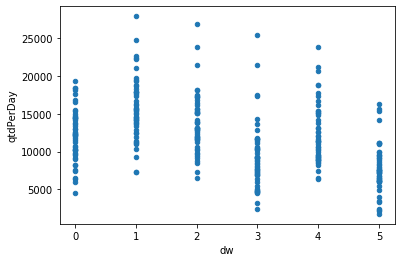

In [15]:
salesPerDay.plot.scatter(x='dw', y='qtdPerDay')

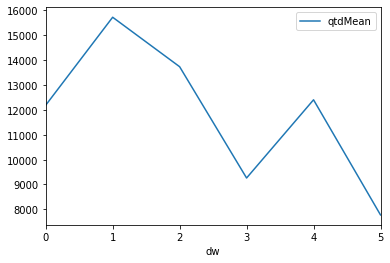

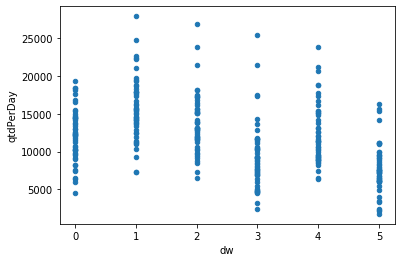

In [16]:
dfweek = salesPerDay.copy()
dfweek['qtdMean'] = dfweek.groupby('dw')['qtdPerDay'].transform('mean')
dfweek.drop(columns=['Data', 'day', 'month', 'year', 'week', 'qtdPerDay'], inplace=True)
dfweek.drop_duplicates(inplace=True)
dfweek
x = dfweek.plot(x='dw', y='qtdMean')
salesPerDay.plot.scatter(x='dw', y='qtdPerDay')

3) Decomposition of time series

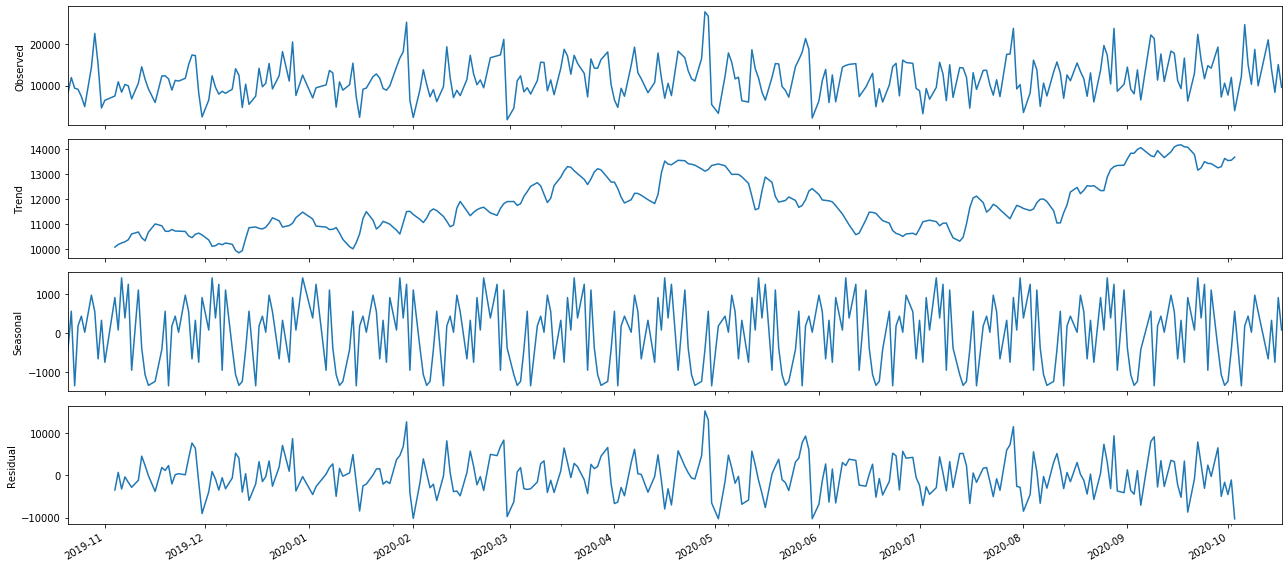

In [17]:
df = salesPerDay.copy()
df.index = df.Data
df.index.name = None

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df.qtdPerDay, freq=22)
fig = decomposition.plot()
plt.show()

### Data Forecasting

1) Naive Forecasting:
First trial is to use Naive Forecasting. We will that the value of the corresponding day is the same as the value of the day of the previous week.

In [12]:
salesPerDay.head(8)

,Data,day,month,year,dw,week,qtdPerDay
0,2019-10-21,21,10,2019,0,43,8196
1,2019-10-22,22,10,2019,1,43,11964
2,2019-10-23,23,10,2019,2,43,9399
3,2019-10-24,24,10,2019,3,43,9131
4,2019-10-25,25,10,2019,4,43,7397
5,2019-10-26,26,10,2019,5,43,4928
6,2019-10-28,28,10,2019,0,44,14441
7,2019-10-29,29,10,2019,1,44,22642


In [18]:
salesPerDay.sort_values(by=['Data'], inplace=True)
salesPerDay.tail()

,Data,day,month,year,dw,week,qtdPerDay
294,2020-10-13,13,10,2020,1,42,21088
295,2020-10-14,14,10,2020,2,42,13879
296,2020-10-15,15,10,2020,3,42,8386
297,2020-10-16,16,10,2020,4,42,15111
298,2020-10-17,17,10,2020,5,42,9600


In [15]:
salesPerDay['qtdPerDay']

0       8196
1      11964
2       9399
3       9131
4       7397
       ...  
294    21088
295    13879
296     8386
297    15111
298     9600
Name: qtdPerDay, Length: 299, dtype: int64

In [36]:
df = salesPerDay.copy()
df.index = pd.to_datetime(df.Data)
df.index.name = None
df.qtdPerDay

2019-10-21     8196
2019-10-22    11964
2019-10-23     9399
2019-10-24     9131
2019-10-25     7397
              ...  
2020-10-13    21088
2020-10-14    13879
2020-10-15     8386
2020-10-16    15111
2020-10-17     9600
Name: qtdPerDay, Length: 299, dtype: int64

Data         datetime64[ns]
day                  object
month                object
year                 object
dw                    int64
week                  int64
qtdPerDay             int64
dtype: object